In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, HuberRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold
from scipy.stats import uniform
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import LeaveOneOut
from sklearn.calibration import cross_val_predict

Define HyperParameter Tuning Method

In [2]:
def grid_tune_hyperparameters(model, param_grid, X_train, y_train):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    
    #using grid search with cross validation
    grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    return best_params

def random_tune_hyperparameters(model, param_grid, X_train, y_train):
    cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=1)

    random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=40, scoring='neg_mean_squared_error', cv=cv, random_state=42)
    
    random_search.fit(X_train, y_train)
    best_params = random_search.best_params_
    
    return best_params

def random_tune_hyperparameters_for_plotting(model, param_grid, X_train, y_train):
    cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=1)

    #use random hyperparameter search with K fold cross validation
    random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=40, scoring='neg_mean_squared_error', cv=cv, random_state=42)
    
    random_search.fit(X_train, y_train)

    return random_search.cv_results_['param_alpha'].data, random_search.cv_results_['mean_test_score']

def polynomial_tune_hyperparameters(degrees, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    bics = {}
    
    for degree in degrees:
        #create features in degree
        poly = PolynomialFeatures(degree=degree)
        X_train_poly = poly.fit_transform(X_train)
        
        #fit model with features
        model_sklearn = LinearRegression()
        model_sklearn.fit(X_train_poly, y_train)
        
        #make predictions
        X_test_poly = poly.transform(X_test)
        y_pred_sklearn = model_sklearn.predict(X_test_poly)
        
        #calculate sum of the squares of errors
        ss_eps = np.sum((y_test - y_pred_sklearn) ** 2)

        #calculate BIC scores
        bic = len(X_train) * np.log(ss_eps) + degree * np.log(len(X_train))
        
        #add to dictionary
        bics[bic] = degree
    
    #identify best performing degree of polynomial
    best_bic = min(bics.keys())
    best_degree = bics[best_bic]
    
    #plot BIC scores
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=list(bics.values()), y=list(bics.keys()), marker='o')
    plt.title("BIC Values for Different Polynomial Degrees on Dimensionality Reduced Data Set")
    plt.xlabel("Polynomial Degree")
    plt.ylabel("BIC")
    plt.savefig("figs/BIC_comparison_PCA.png")
    plt.show()
    return best_degree

Run BIC comparison test for polynomial regression

In [ ]:
df = pd.read_csv("pca_reduced_dataset.csv")

# Extract features and target
X = df.drop(columns=["quality"])
y = df['quality']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Specify the degree of the polynomial
degrees = range(1, 9)  # You can expand this list with more degrees to try

# Create polynomial features
poly = PolynomialFeatures()

best_degree = polynomial_tune_hyperparameters(degrees, X_train, y_train)

print(best_degree)
# Use the best degree to create polynomial features
poly = PolynomialFeatures(degree=best_degree)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Train a linear regression model on the polynomial features
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_poly)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Define Method to find rough optimal hyperparameters on Degree 1

In [ ]:
def find_hyperparams(df, title):
    X = df.drop(columns=['quality'])
    y = df['quality']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    #tune hyperparameters for all the models  
    ridge_hyperparams_grid = {'alpha': uniform(loc=0.00001, scale=0.99999)}
    best_ridge_params = random_tune_hyperparameters(Ridge(), ridge_hyperparams_grid, X_train, y_train)
    print(best_ridge_params)

    lasso_hyperparams = {'alpha':  uniform(loc=0.00001, scale=0.99999)}
    best_lasso_params = random_tune_hyperparameters(Lasso(), lasso_hyperparams, X_train, y_train)
    print(best_lasso_params)

    huber_hyperparams = {'alpha': uniform(loc=0.00001, scale=0.99999), 'epsilon': uniform(loc=0.1, scale=9.9)}
    best_huber_params = random_tune_hyperparameters(HuberRegressor(max_iter=1000), huber_hyperparams, X_train, y_train)
    print(best_huber_params)
    
    #fit models
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)

    ridge_reg = Ridge(alpha=best_ridge_params['alpha'])
    ridge_reg.fit(X_train, y_train)

    lasso_reg = Lasso(alpha=best_lasso_params['alpha'])
    lasso_reg.fit(X_train, y_train)

    Huber_reg = HuberRegressor(alpha=best_huber_params['alpha'], epsilon=best_huber_params['epsilon'],max_iter=1000)
    Huber_reg.fit(X_train, y_train)

    #make predictions
    y_pred_lin = lin_reg.predict(X_test)
    y_pred_ridge = ridge_reg.predict(X_test)
    y_pred_lasso = lasso_reg.predict(X_test)
    y_pred_huber = Huber_reg.predict(X_test)

    #evaluate with MSE metric
    mse_lin = mean_squared_error(y_test, y_pred_lin)
    mse_ridge = mean_squared_error(y_test, y_pred_ridge)
    mse_lasso = mean_squared_error(y_test, y_pred_lasso)
    mse_huber = mean_squared_error(y_test, y_pred_huber)

    #evaluate with MAE metric
    mae_lin = mean_absolute_error(y_test, y_pred_lin)
    mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
    mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
    mae_huber = mean_absolute_error(y_test, y_pred_huber)

    #find largest error made by each of the models
    max_error_lin = np.max(np.abs(y_test - y_pred_lin))
    max_error_ridge = np.max(np.abs(y_test - y_pred_ridge))
    max_error_lasso = np.max(np.abs(y_test - y_pred_lasso))
    max_error_huber = np.max(np.abs(y_test - y_pred_huber))
    
    #print results
    print(f"for {title}:")

    print("\nModel Evaluations on unaltered dataset:\n")
    print("\nLinear Regression MSE:", mse_lin)
    print("Ridge Regression MSE:", mse_ridge)
    print("Lasso Regression MSE:", mse_lasso)
    print("Huber Regression MSE:", mse_huber)

    print("\nLinear Regression MAE:", mae_lin)
    print("Ridge Regression MAE:", mae_ridge)
    print("Lasso Regression MAE:", mae_lasso)
    print("Huber Regression MAE:", mae_huber)
    
    print("Largest Error made by models: \n")

    print("\nMaximum Error - Linear Regression:", max_error_lin)
    print("Maximum Error - Ridge Regression:", max_error_ridge)
    print("Maximum Error - Lasso Regression:", max_error_lasso)
    print("Maximum Error - Huber Regression:", max_error_huber)


Define Method to find rough optimal hyperparameters on Degree 2

In [ ]:
def find_hyperparams_degree_2(df, title):
    X = df.drop(columns=['quality'])
    y = df['quality']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    #create features in degree 2
    poly = PolynomialFeatures(degree=2)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    #tune hyperparameters for all the models
    ridge_hyperparams_grid = {'alpha': uniform(loc=0.00001, scale=0.99999)}
    best_ridge_params = random_tune_hyperparameters(Ridge(), ridge_hyperparams_grid, X_train_poly, y_train)

    lasso_hyperparams = {'alpha':  uniform(loc=0.00001, scale=0.99999)}
    best_lasso_params = random_tune_hyperparameters(Lasso(), lasso_hyperparams, X_train_poly, y_train)

    huber_hyperparams = {'alpha': uniform(loc=0.00001, scale=0.99999), 'epsilon': uniform(loc=0.1, scale=9.9)}
    best_huber_params = random_tune_hyperparameters(HuberRegressor(max_iter=1000), huber_hyperparams, X_train_poly, y_train)
    
    #fit models with ideal hyperparameter values
    lin_reg = LinearRegression()
    lin_reg.fit(X_train_poly, y_train)
    print("\nLinear Regression Coefficients:", lin_reg.coef_)

    ridge_reg = Ridge(alpha=best_ridge_params['alpha'])
    ridge_reg.fit(X_train_poly, y_train)
    print("\nRidge Regression Coefficients:", ridge_reg.coef_)

    lasso_reg = Lasso(alpha=best_lasso_params['alpha'])
    lasso_reg.fit(X_train_poly, y_train)
    print("\nLasso Regression Coefficients:", lasso_reg.coef_)

    Huber_reg = HuberRegressor(alpha=best_huber_params['alpha'], epsilon=best_huber_params['epsilon'],max_iter=1000)
    Huber_reg.fit(X_train_poly, y_train)
    print("\nHuber Regression Coefficients:", Huber_reg.coef_)


    #make predictions
    y_pred_lin = lin_reg.predict(X_test_poly)
    y_pred_ridge = ridge_reg.predict(X_test_poly)
    y_pred_lasso = lasso_reg.predict(X_test_poly)
    y_pred_huber = Huber_reg.predict(X_test_poly)

    #evaluate with MSE metric
    mse_lin = mean_squared_error(y_test, y_pred_lin)
    mse_ridge = mean_squared_error(y_test, y_pred_ridge)
    mse_lasso = mean_squared_error(y_test, y_pred_lasso)
    mse_huber = mean_squared_error(y_test, y_pred_huber)

    #evaluate with MAE metric
    mae_lin = mean_absolute_error(y_test, y_pred_lin)
    mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
    mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
    mae_huber = mean_absolute_error(y_test, y_pred_huber)

    #find largest error made by each of the models
    max_error_lin = np.max(np.abs(y_test - y_pred_lin))
    max_error_ridge = np.max(np.abs(y_test - y_pred_ridge))
    max_error_lasso = np.max(np.abs(y_test - y_pred_lasso))
    max_error_huber = np.max(np.abs(y_test - y_pred_huber))
    
    #print results
    print(f"for {title}:")

    print("\nModel Evaluations on unaltered dataset:\n")
    print("\nLinear Regression MSE:", mse_lin)
    print("Ridge Regression MSE:", mse_ridge)
    print("Lasso Regression MSE:", mse_lasso)
    print("Huber Regression MSE:", mse_huber)

    print("\nLinear Regression MAE:", mae_lin)
    print("Ridge Regression MAE:", mae_ridge)
    print("Lasso Regression MAE:", mae_lasso)
    print("Huber Regression MAE:", mae_huber)
    
    print("Largest Error made by models: \n")

    print("\nMaximum Error - Linear Regression:", max_error_lin)
    print("Maximum Error - Ridge Regression:", max_error_ridge)
    print("Maximum Error - Lasso Regression:", max_error_lasso)
    print("Maximum Error - Huber Regression:", max_error_huber)


In [ ]:
def find_hyperparams_degree_2_plot(df):
    X = df.drop(columns=['quality'])
    y = df['quality']
    
    #create features in degree 2
    poly = PolynomialFeatures(degree=2)
    X_train_poly = poly.fit_transform(X)

    #tune hyperparameters for Ridge Regression
    ridge_hyperparams_grid = {'alpha': uniform(loc=0.00001, scale=0.99999)}
    all_ridge_alphas, all_ridge_mse_scores = random_tune_hyperparameters_for_plotting(Ridge(), ridge_hyperparams_grid, X_train_poly, y)
    
    all_ridge_mse_scores = -1 * all_ridge_mse_scores


    #plot alpha values against MSE
    plt.scatter(all_ridge_alphas, all_ridge_mse_scores)
    plt.title('Alpha vs. MSE: Ridge Regularised')
    plt.xlabel('Alpha Values')
    plt.ylabel('Mean Squared Error')
    plt.savefig('figs/alpha_plotting.png')
    plt.show()

use original dataset to find rough hyperparameter ranges / performances with random CV search

In [ ]:
#df = pd.read_csv("winequality-red.csv")

#find_hyperparams(df, "Original, Unaltered Dataset")

df = pd.read_csv("feature_scaled_dataset.csv")

find_hyperparams_degree_2_plot(df)

Define Method to Test Dataset with Multiple Regression Models with Degree 1 Regression

In [ ]:
def test_dataset_degree_1(df, title):
    X = df.drop(columns=['quality'])
    y = df['quality']


    #split dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    #tune hyperparameters for all the models 
    ridge_hyperparams_grid = {'alpha': np.arange(0.4, 0.44, 0.001)}
    best_ridge_params = grid_tune_hyperparameters(Ridge(), ridge_hyperparams_grid, X_train, y_train)

    lasso_hyperparams = {'alpha':  np.arange(0.00001, 0.001, 0.0001 )}
    best_lasso_params = grid_tune_hyperparameters(Lasso(), lasso_hyperparams, X_train, y_train)

    huber_hyperparams = {'alpha': [0.58,0.59,0.60,0.61], 'epsilon': [6.9, 7.0, 7.1]}
    best_huber_params = grid_tune_hyperparameters(HuberRegressor(max_iter=1000), huber_hyperparams, X_train, y_train)


    #train models
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)

    ridge_reg = Ridge(alpha=best_ridge_params['alpha'])
    ridge_reg.fit(X_train, y_train)

    lasso_reg = Lasso(alpha=best_lasso_params['alpha'])
    lasso_reg.fit(X_train, y_train)
    print("Lasso regression coefficients: ")

    Huber_reg = HuberRegressor(alpha=best_huber_params['alpha'], epsilon=best_huber_params['epsilon'],max_iter=1000)
    Huber_reg.fit(X_train, y_train)

    #make predictions
    y_pred_lin = lin_reg.predict(X_test)
    y_pred_ridge = ridge_reg.predict(X_test)
    y_pred_lasso = lasso_reg.predict(X_test)
    y_pred_huber = Huber_reg.predict(X_test)

    #evaluate with MSE metric
    mse_lin = mean_squared_error(y_test, y_pred_lin)
    mse_ridge = mean_squared_error(y_test, y_pred_ridge)
    mse_lasso = mean_squared_error(y_test, y_pred_lasso)
    mse_huber = mean_squared_error(y_test, y_pred_huber)

    #evaluation with MAE metric
    mae_lin = mean_absolute_error(y_test, y_pred_lin)
    mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
    mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
    mae_huber = mean_absolute_error(y_test, y_pred_huber)

    #find largest error made by each of the models
    max_error_lin = np.max(np.abs(y_test - y_pred_lin))
    max_error_ridge = np.max(np.abs(y_test - y_pred_ridge))
    max_error_lasso = np.max(np.abs(y_test - y_pred_lasso))
    max_error_huber = np.max(np.abs(y_test - y_pred_huber))
    
    #print results
    print(f"for {title}:")

    print("\nModel Evaluations on unaltered dataset:\n")
    print("\nLinear Regression MSE:", mse_lin)
    print("Ridge Regression MSE:", mse_ridge)
    print("Lasso Regression MSE:", mse_lasso)
    print("Huber Regression MSE:", mse_huber)

    print("\nLinear Regression MAE:", mae_lin)
    print("Ridge Regression MAE:", mae_ridge)
    print("Lasso Regression MAE:", mae_lasso)
    print("Huber Regression MAE:", mae_huber)
    
    print("Largest Error made by models: \n")

    print("\nMaximum Error - Linear Regression:", max_error_lin)
    print("Maximum Error - Ridge Regression:", max_error_ridge)
    print("Maximum Error - Lasso Regression:", max_error_lasso)
    print("Maximum Error - Huber Regression:", max_error_huber)

Define Method to Test Dataset with Multiple Regression Models with Degree 2 Regression

In [ ]:
def test_dataset_degree_2(df, title):
    X = df.drop(columns=['quality'])
    y = df['quality']
    
    #initialise corss validation method
    loocv = LeaveOneOut()


    #split dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

    #create features in degree 2
    poly = PolynomialFeatures(degree=2)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    #tune hyperparameters for all the models
    ridge_hyperparams_grid = {'alpha': np.arange(0.4, 0.44, 0.001)}
    best_ridge_params = grid_tune_hyperparameters(Ridge(), ridge_hyperparams_grid, X_train_poly, y_train)

    lasso_hyperparams = {'alpha': np.arange(0.00001, 0.001, 0.0001)}
    best_lasso_params = grid_tune_hyperparameters(Lasso(), lasso_hyperparams, X_train_poly, y_train)

    huber_hyperparams = {'alpha': [0.58, 0.59, 0.60, 0.61], 'epsilon': [6.9, 7.0, 7.1]}
    best_huber_params = grid_tune_hyperparameters(HuberRegressor(max_iter=1000), huber_hyperparams, X_train_poly, y_train)


    #train models
    lin_reg = LinearRegression()
    lin_reg.fit(X_train_poly, y_train)

    ridge_reg = Ridge(alpha=best_ridge_params['alpha'])
    ridge_reg.fit(X_train_poly, y_train)

    lasso_reg = Lasso(alpha=best_lasso_params['alpha'])
    lasso_reg.fit(X_train_poly, y_train)
    
    Huber_reg = HuberRegressor(alpha=best_huber_params['alpha'], epsilon=best_huber_params['epsilon'],max_iter=1000)
    Huber_reg.fit(X_train_poly, y_train)
    
    #make predictions with leave one out cross validation method
    y_pred_lin = cross_val_predict(lin_reg, X_test_poly, y_test, cv=loocv)
    y_pred_ridge = cross_val_predict(ridge_reg, X_test_poly, y_test, cv=loocv)
    y_pred_lasso = cross_val_predict(lasso_reg, X_test_poly, y_test, cv=loocv)
    y_pred_huber = cross_val_predict(Huber_reg, X_test_poly, y_test, cv=loocv)

    

    #evaluate with MSE metric
    mse_lin = mean_squared_error(y_test, y_pred_lin)
    mse_ridge = mean_squared_error(y_test, y_pred_ridge)
    mse_lasso = mean_squared_error(y_test, y_pred_lasso)
    mse_huber = mean_squared_error(y_test, y_pred_huber)

    #evaluate with MAE metric
    mae_lin = mean_absolute_error(y_test, y_pred_lin)
    mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
    mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
    mae_huber = mean_absolute_error(y_test, y_pred_huber)

    #find largest error made by each of the models
    max_error_lin = np.max(np.abs(y_test - y_pred_lin))
    max_error_ridge = np.max(np.abs(y_test - y_pred_ridge))
    max_error_lasso = np.max(np.abs(y_test - y_pred_lasso))
    max_error_huber = np.max(np.abs(y_test - y_pred_huber))

    #print results
    print(f"for {title}:")

    print(f"\nModel Evaluations on: {title}\n")
    print("\nLinear Regression MSE:", mse_lin)
    print("Ridge Regression MSE:", mse_ridge)
    print("Lasso Regression MSE:", mse_lasso)
    print("Huber Regression MSE:", mse_huber)

    print("\nLinear Regression MAE:", mae_lin)
    print("Ridge Regression MAE:", mae_ridge)
    print("Lasso Regression MAE:", mae_lasso)
    print("Huber Regression MAE:", mae_huber)

    print("Largest Error made by models: \n")

    print("\nMaximum Error - Linear Regression:", max_error_lin)
    print("Maximum Error - Ridge Regression:", max_error_ridge)
    print("Maximum Error - Lasso Regression:", max_error_lasso)
    print("Maximum Error - Huber Regression:", max_error_huber)
    
    return [[mse_lin, mae_lin],[mse_huber, mae_huber],[mse_lasso, mae_lasso],[mse_ridge, mae_ridge]], [lin_reg, Huber_reg, lasso_reg, ridge_reg]

Test Models with Original Dataset

In [ ]:
df = pd.read_csv("winequality-red.csv", sep=';')

test_dataset_degree_1(df, "Original, Unaltered Dataset")

Test Models with PCA Reduced Dataset

In [ ]:
df = pd.read_csv("pca_reduced_dataset.csv")

scores_PCA, models = test_dataset_degree_2(df, "PCA Reduced Dataset")
MSEs = {}
MAEs = {}
target_variable = "quality"

#list of quality values to extract
quality_values_to_extract = [6, 7, 8]

#extract records with specified quality values
selected_records = df[df[target_variable].isin(quality_values_to_extract)]

#split dataset into features and target
X = selected_records.drop(columns=["quality"])
y = selected_records["quality"]

#create features in degree 2
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

#evaluate model performances on outlier records
for x, model in enumerate(models):
    pred = model.predict(X_poly)
    MSEs[x] = [mean_squared_error(y, pred)]
    MAEs[x] = [mean_absolute_error(y, pred)]

Test Models with Dataset with Composite Acidity Feature

In [ ]:
df = pd.read_csv("combined_acid_dataset.csv")

test_dataset_degree_1(df, "Composite Acidity Feature Dataset")

Test Models with Feature Scaled Dataset

In [ ]:
df = pd.read_csv("feature_scaled_dataset.csv")

#test_dataset_degree_1(df, "Feature Scaled Dataset With Degree 1 Polynomial")

scores_feature, models = test_dataset_degree_2(df, "Feature Scaled Dataset With Degree 2 Polynomial")

target_variable = "quality"

#list of quality values to extract
quality_values_to_extract = [6, 7, 8]

#extract records with specified quality values
selected_records = df[df[target_variable].isin(quality_values_to_extract)]

#split dataset into features and target
X = selected_records.drop(columns=["quality"])
y = selected_records["quality"]

#create features in degree 2
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

#evaluate model performances on outlier records
for x, model in enumerate(models):
    pred = model.predict(X_poly)
    MSEs[x].append(mean_squared_error(y, pred))
    MAEs[x].append(mean_absolute_error(y, pred))


Experiment with custom hyperparameter to artificially steepen predictions

In [ ]:
from sklearn.discriminant_analysis import StandardScaler

def create_plot(y_pred, y_test, title):

    #flatten arrays
    y_pred_flat = np.array(y_pred).flatten()
    y_test_flat = np.array(y_test).flatten()

    #create DataFrame for plotting
    plot_data = pd.DataFrame({'Actual': y_test_flat, 'Predicted': y_pred_flat})

    #create violin plot
    plt.figure(figsize=(12, 8))
    sns.violinplot(x='Actual', y='Predicted', data=plot_data, inner='quartile')
    
    plt.title(f'Actual vs. Predicted - {title}')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    #plt.savefig(f'figs/{title.split(" ")[0]}_violin.png')
    plt.show()


def repeated_kfold_hyperparameter_search(param_grid, X, y, n_splits=5, n_repeats=10):
    
    y_mean = y.mean()
    best_params = None
    best_score = float('inf')
    y_scaler = StandardScaler()
    y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1))
    
    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(X)
    
    X_overall_train, X_overall_test, y_overall_train, y_overall_test = train_test_split(X_poly, y_scaled, test_size=0.4, random_state=42)
    y_overall_train = pd.Series(y_overall_train.flatten())
    
    m = X_overall_train.shape[0]
    indices = np.arange(m)


    for _ in range(n_repeats):
        np.random.shuffle(indices)

        for split in range(n_splits):
            split_size = m // n_splits
            val_start = split * split_size
            val_end = (split + 1) * split_size
            val_indices = indices[val_start:val_end]
            train_indices = np.concatenate([indices[:val_start], indices[val_end:]])

            X_train, X_val = X_overall_train[train_indices], X_overall_train[val_indices]
            y_train, y_val = y_overall_train.iloc[train_indices], y_overall_train.iloc[val_indices]

            for alpha in param_grid["alpha"]:
                current_ridge_reg = Ridge(alpha=alpha)
                current_ridge_reg.fit(X_train, y_train)

                y_pred_val = current_ridge_reg.predict(X_val)

                for beta in param_grid["beta"]:

                    y_pred_val_updated = np.where(y_pred_val >= y_mean, y_pred_val * beta, y_pred_val / beta)
                                        
                    # Calculate the score using the specified metric
                    score = mean_squared_error(y_val, y_pred_val_updated)

                    # Update best hyperparameters if the current score is better
                    if score < best_score:
                        best_score = score
                        best_params = {"alpha": alpha, "beta": beta}

    results = {
        'best_params': best_params,
        'best_score': best_score
    }
    print(results)
    
    ridge_reg = Ridge(alpha=results["best_params"]["alpha"])
    ridge_reg.fit(X_overall_train, y_overall_train)

    y_pred = ridge_reg.predict(X_overall_test)
    y_pred_val_updated = np.where(y_pred >= y_mean, y_pred * results["best_params"]["beta"], y_pred / results["best_params"]["beta"])
    
    y_pred_val_updated

    create_plot(
        y_scaler.inverse_transform(y_pred_val_updated.reshape(-1, 1)),
        y_scaler.inverse_transform(y_overall_test.reshape(-1, 1)),
        'Ridge Regression'
    )



df = pd.read_csv('pca_reduced_dataset.csv')
X = df.drop(columns=['quality'])
y = df['quality']

results = repeated_kfold_hyperparameter_search(
    {"alpha": np.arange(0, 5, 0.1), "beta": np.arange(1, 1.3, 0.01)},
    X, y
)

1.0603124801479806
0.4197587402167146


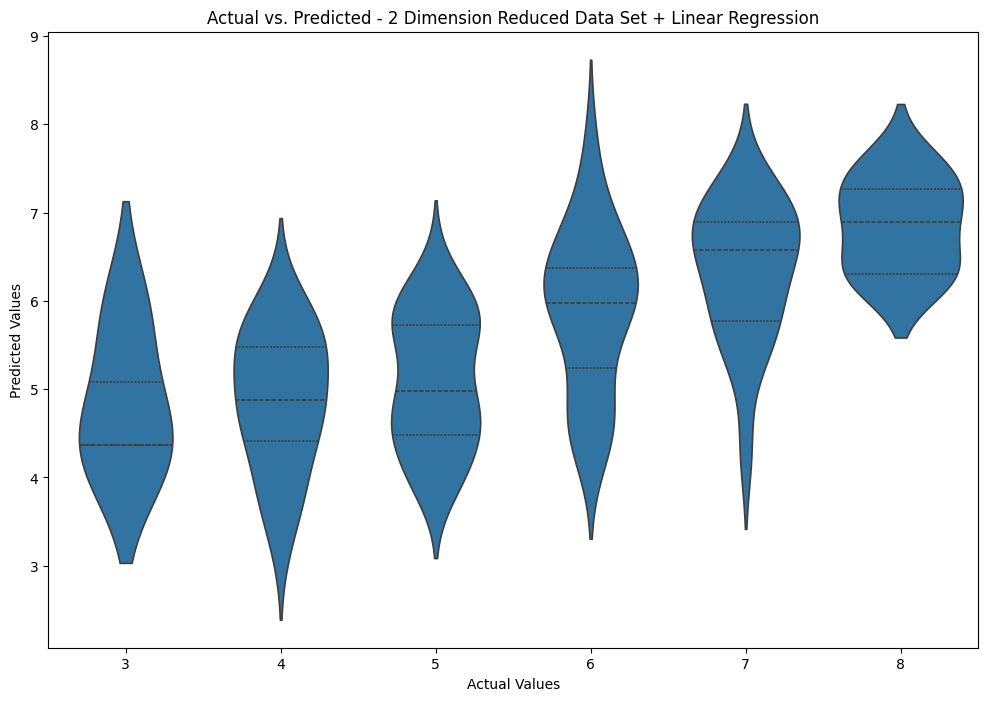

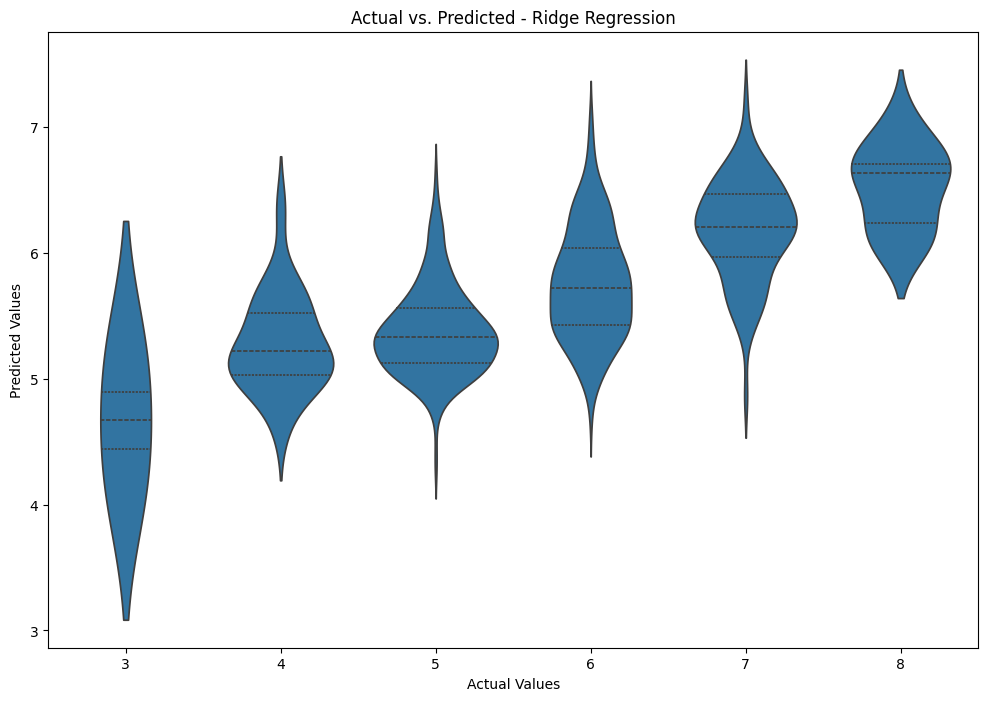

In [9]:
def create_plot(y_pred, y_test, title, loocv):

    #create a DataFrame for plotting
    plot_data = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

    #create a violin plot
    plt.figure(figsize=(12, 8))
    sns.violinplot(x='Actual', y='Predicted', data=plot_data, inner='quartile')
    
    plt.title(f'Actual vs. Predicted - {title}')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.savefig(f'figs/{title.split(" ")[0]}_violin.png')
    plt.show()
    

def plot_performances(df1, df2):
    #split datasets
    X1 = df1.drop(columns=['quality'])
    y1 = df1['quality']
    
    X2 = df2.drop(columns=['quality'])
    y2 = df2['quality']
    
    #define cross validation method
    loocv = LeaveOneOut()

    #split datasets
    X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.4, random_state=42)
    X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.4, random_state=42)

    #create polynomial features for ridge dataset
    poly = PolynomialFeatures(degree=2)
    
    #split datasets
    X2_train_poly = poly.fit_transform(X2_train)
    X2_test_poly = poly.transform(X2_test)

    X1_train_poly = X1_train
    X1_test_poly = X1_test

    #tune hyperparameters for Ridge Regression
    ridge_hyperparams_grid = {'alpha': np.arange(0.2, 0.35, 0.001)}
    best_ridge_params = grid_tune_hyperparameters(Ridge(), ridge_hyperparams_grid, X2_train_poly, y2_train)
    
    #train models with leave one out cross validation method, make predictions  and print MSE values
    pca_lin_reg = LinearRegression()
    pca_lin_reg.fit(X1_train_poly, y1_train)

    lin_y_pred = cross_val_predict(pca_lin_reg, X1_test_poly, y1_test, cv=loocv)

    print(mean_squared_error(lin_y_pred, y1_test))

    ridge_reg = Ridge(alpha=best_ridge_params['alpha'])
    ridge_reg.fit(X2_train_poly, y2_train)
    
    
    reg_y_pred = cross_val_predict(ridge_reg, X2_test_poly, y2_test, cv=loocv)
    
    print(mean_squared_error(reg_y_pred, y2_test))


    #create plots
    create_plot(lin_y_pred, y1_test, '2 Dimension Reduced Data Set + Linear Regression', loocv)
    create_plot(reg_y_pred, y2_test, 'Ridge Regression', loocv)
    
df1 = pd.read_csv('pca_reduced_dataset.csv')

df2 = pd.read_csv('feature_scaled_dataset.csv')

plot_performances(df1, df2)